<a href="https://colab.research.google.com/github/MehrdadJalali-KIT/XPS_Spectrum/blob/main/XPS_Model_5Components.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Mount drive
from google.colab import drive
import os

drive.mount('/content/drive')
# Change working path
os.chdir('/content/drive/MyDrive/Research/XPS')

Mounted at /content/drive


Epoch 1/50
141/141 [==============================] - 27s 175ms/step - loss: 6.2146 - val_loss: 4.0288
Epoch 2/50
141/141 [==============================] - 22s 156ms/step - loss: 2.5666 - val_loss: 1.4115
Epoch 3/50
141/141 [==============================] - 26s 180ms/step - loss: 0.9229 - val_loss: 0.6302
Epoch 4/50
141/141 [==============================] - 22s 158ms/step - loss: 0.4745 - val_loss: 0.3516
Epoch 5/50
141/141 [==============================] - 26s 184ms/step - loss: 0.2722 - val_loss: 0.2304
Epoch 6/50
141/141 [==============================] - 23s 166ms/step - loss: 0.1787 - val_loss: 0.1588
Epoch 7/50
141/141 [==============================] - 25s 175ms/step - loss: 0.1274 - val_loss: 0.1201
Epoch 8/50
141/141 [==============================] - 23s 166ms/step - loss: 0.0969 - val_loss: 0.0924
Epoch 9/50
141/141 [==============================] - 24s 172ms/step - loss: 0.0783 - val_loss: 0.0799
Epoch 10/50
141/141 [==============================] - 26s 182ms/step - l

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 1s 45ms/step
Root Mean Squared Error (RMSE) on validation set: 0.12041939468098334


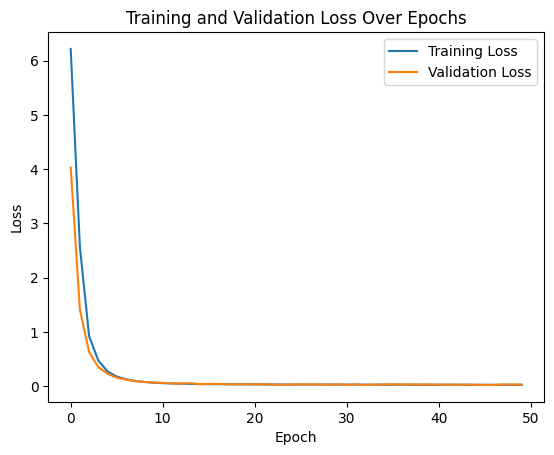

In [26]:
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, Dropout, Flatten, Dense, AveragePooling1D
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np

np.random.seed(56)
random.seed(56)
tf.random.set_seed(56)

# Function to generate a spectrum as a sum of Gaussians
def generate_spectrum_sum_gaussians(amplitudes, centers, fwhms):
    x_range = np.arange(94.45, 109.45, 0.05)
    peaks = []
    for i in range(len(centers)):
        fwhm = fwhms[i]
        if i == 1:  # For Si_Comp2
            peak =  amplitudes[0] * np.exp(-(x_range - centers[i])**2 / (2 * (fwhm / (2 * np.sqrt(2 * np.log(2)) ))**2))  # Gaussian peak with FWHM, multiplied by 0.5 for intensity ratio
        else:
            peak = amplitudes[i] * np.exp(-(x_range - centers[i])**2 / (2 * (fwhm / (2 * np.sqrt(2 * np.log(2)) ))**2))  # Gaussian peak with FWHM
        peaks.append(peak)
    return np.sum(peaks, axis=0)

# Adjusted specific frequencies with conditional random value additions
freq_Si_Comp1 = 99.0 + np.random.uniform(-0.1, 0.1)
freq_Si_Comp2 = freq_Si_Comp1 + 0.6

adjustedFrequencies = {
    freq_Si_Comp1: ('Si_Comp1', 1.20),
    freq_Si_Comp2: ('Si_Comp2', 1.20),  # Set FWHM of Si_Comp2 same as Si_Comp1
    100.4 + np.random.uniform(-0.5, 0.5): ('SiC', 1.65),
    101.6 + np.random.uniform(-0.3, 0.3): ('SiN', 1.65),
    103.1 + np.random.uniform(-0.3, 0.3): ('SiO2', 1.65)
}

# Generate amplitudes for spectra data
num_amplitudes = len(adjustedFrequencies)
num_spectra = 5000
centers = [center for center, _ in adjustedFrequencies.items()]
fwhm_constants = [fwhm for _, (_, fwhm) in adjustedFrequencies.items()]
fwhm_uncertainties = [0.1] * len(adjustedFrequencies)

spectraDataAmplitudesList = []
for i in range(num_spectra):
    amplitudes = np.random.rand(num_amplitudes)
    fwhms = np.random.uniform(np.array(fwhm_constants) - np.array(fwhm_uncertainties), np.array(fwhm_constants) + np.array(fwhm_uncertainties))
    amplitudes[1] = 0.5 * amplitudes[0]
    spectrum = generate_spectrum_sum_gaussians(amplitudes, centers, fwhms)
    spectraDataAmplitudesList.append((spectrum, amplitudes))

random.shuffle(spectraDataAmplitudesList)

spectraData = np.array([data[0] for data in spectraDataAmplitudesList])
amplitudesData = np.array([data[1] for data in spectraDataAmplitudesList])

# Reshape the spectra data
num_samples, points_per_spectrum = spectraData.shape
num_components = len(adjustedFrequencies)
spectraData = np.reshape(spectraData, (num_samples, points_per_spectrum, 1))

# Define the input shape
input_shape = spectraData.shape[1:]

# Define the model architecture
model = Sequential([
    Conv1D(32, 5, strides=1, activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l1(0.0001)),
    Dropout(0.3),
    Conv1D(32, 5, activation='relu'),
    AveragePooling1D(pool_size=2, strides=2),
    Conv1D(64, 5, activation='relu'),
    Dropout(0.3),
    Conv1D(64, 5, activation='relu'),
    AveragePooling1D(pool_size=2, strides=2),
    Conv1D(128, 5, activation='relu'),
    Dropout(0.4),
    Conv1D(128, 5, activation='relu'),
    Dropout(0.4),
    AveragePooling1D(pool_size=2, strides=2),
    Flatten(),
    Dense(1024, activation='relu', kernel_regularizer=regularizers.l1(0.0001)),
    Dropout(0.5),
    Dense(512, activation='relu', kernel_regularizer=regularizers.l1(0.0001)),
    Dropout(0.5),
    Dense(num_components, activation='relu', kernel_regularizer=regularizers.l1(0.0001))
])

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(spectraData, amplitudesData, test_size=0.1, random_state=56)

# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))

# Save the model
model.save('CNN_Model_Component_Binding_Energies_v3.h5')

# Make predictions on the validation set
y_pred = model.predict(X_val)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

# Print RMSE
print(f'Root Mean Squared Error (RMSE) on validation set: {rmse}')

# Plotting the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


1/1 [==============================] - 0s 149ms/step


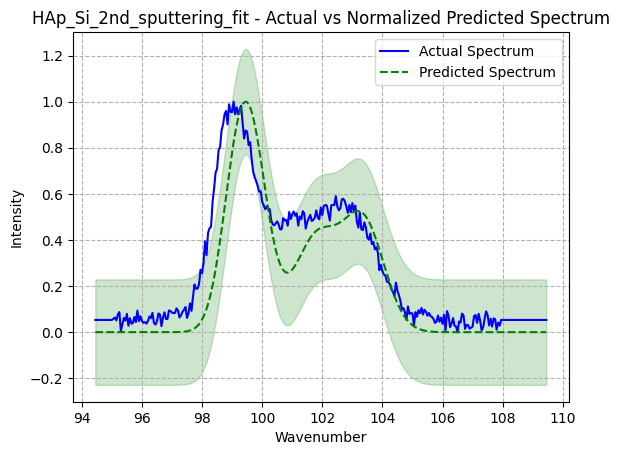

In [38]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
import os

# Load the saved model
model = load_model('CNN_Model_Component_Binding_Energies_v3.h5')

# Function to generate multiple spectra as a sum of Gaussians
def generate_multiple_spectra(amplitudes, centers, fwhms):
    x_range = np.arange(94.45, 109.45, 0.05)
    peaks = []
    for i in range(len(centers)):
        fwhm = fwhms[i]
        if i == 1:  # For Si_Comp2
            peak = amplitudes[0] * np.exp(-(x_range - centers[i])**2 / (2 * (fwhm / (2 * np.sqrt(2 * np.log(2))))**2))  # Gaussian peak with FWHM, multiplied by 0.5 for intensity ratio
        else:
            peak = amplitudes[i] * np.exp(-(x_range - centers[i])**2 / (2 * (fwhm / (2 * np.sqrt(2 * np.log(2))))**2))  # Gaussian peak with FWHM
        peaks.append(peak)
    return np.sum(peaks, axis=0)

# Define components with binding energies and FWHMs
# Adjusted specific frequencies with conditional random value additions
freq_Si_Comp1 = 99.0 + np.random.uniform(-0.1, 0.1)
freq_Si_Comp2 = freq_Si_Comp1 + 0.6

components = {
    freq_Si_Comp1: ('Si_Comp1', 1.20),
    freq_Si_Comp2: ('Si_Comp2', 1.20),  # Set FWHM of Si_Comp2 same as Si_Comp1
    100.4 + np.random.uniform(-0.5, 0.5): ('SiC', 1.65),
    101.6 + np.random.uniform(-0.3, 0.3): ('SiN', 1.65),
    103.1 + np.random.uniform(-0.3, 0.3): ('SiO2', 1.65)
}

# Convert component frequencies to float
centers = [float(key) for key in components.keys()]

# Load new data from CSV
file_path = 'ExperimentalData/HAp_Si_2nd_sputtering_fit.csv'
data = pd.read_csv(file_path, names=["Wavenumber", "Intensity"])
file_name = os.path.splitext(os.path.basename(file_path))[0]  # Extracts the file name without extension

# Define spectrum range
spectrum_min, spectrum_max = 94.45, 109.45

data['Wavenumber'] = pd.to_numeric(data['Wavenumber'], errors='coerce')
data['Intensity'] = pd.to_numeric(data['Intensity'], errors='coerce')

# Filter data within the specified wavenumber range
filtered_data = data[(data['Wavenumber'] >= spectrum_min) & (data['Wavenumber'] <= spectrum_max)].copy()
filtered_data = filtered_data.dropna(subset=['Intensity'])

# Preprocess the filtered data
min_value = np.min(filtered_data['Intensity'])
max_value = np.max(filtered_data['Intensity'])
spectraData_normalized = (filtered_data['Intensity'] - min_value) / (max_value - min_value)
filtered_data['Intensity'] = spectraData_normalized

# Prepare data for interpolation
x = filtered_data['Wavenumber']
y = filtered_data['Intensity']
x_normalized = (x - spectrum_min) / (spectrum_max - spectrum_min)

# Define the number of specific frequencies
num_specific_frequencies = 4

# Interpolate intensity values
f = interp1d(x_normalized, y, kind='linear', fill_value="extrapolate")
start = 94.45
end = 109.45
step = 0.05
num_points = int((end - start) / step)
new_x = np.linspace(0, 1, num_points)

interpolated_intensity = f(new_x)
interpolated_intensity = interpolated_intensity.reshape(1, -1, 1)  # Reshape for prediction

# Predict amplitudes
predicted_amplitudes = model.predict(interpolated_intensity)
predicted_amplitudes_flat = predicted_amplitudes.flatten()

# Calculate the spectrum of predicted amplitudes
predicted_spectrum = generate_multiple_spectra(predicted_amplitudes_flat, centers, [comp[1] for comp in components.values()])

# Normalize the predicted spectrum
predicted_spectrum_normalized = (predicted_spectrum - np.min(predicted_spectrum)) / (np.max(predicted_spectrum) - np.min(predicted_spectrum))

# Calculate the total intensity of the predicted spectrum after normalization
total_intensity_normalized = np.sum(predicted_spectrum_normalized)

# Plot both the actual and normalized predicted spectra
plt.plot(filtered_data['Wavenumber'], filtered_data['Intensity'], label='Actual Spectrum', color='blue', linestyle='-')

plt.plot(new_x * (spectrum_max - spectrum_min) + spectrum_min, predicted_spectrum_normalized, label='Predicted Spectrum', color='green', linestyle='--')

# Calculate the standard deviation of the predicted spectrum
std_predicted_spectrum = np.std(predicted_spectrum)

# Fill between predicted spectrum +/- 1 standard deviation
plt.fill_between(new_x * (spectrum_max - spectrum_min) + spectrum_min, predicted_spectrum_normalized - std_predicted_spectrum, predicted_spectrum_normalized + std_predicted_spectrum, color='green', alpha=0.2)

# Add a table with labels for the portions of each component based on predicted amplitudes
total_intensity = np.sum(predicted_amplitudes_flat)
# table_data = [['Component', 'Portion']]
# for component_name, (component_energy, _) in components.items():
#     component_amplitude = predicted_amplitudes_flat[centers.index(float(component_energy))]
#     portion = component_amplitude / total_intensity
#     table_data.append([component_name, f'{portion * 100:.2f}%'])

# # Create a table with custom font properties
# table = plt.table(cellText=table_data, loc='center left', colWidths=[0.2, 0.2], cellLoc='center', colLabels=None)
# table.auto_set_font_size(False)
# table.set_fontsize(8)

# Add file name to the plot title
plt.title(f'{file_name} - Actual vs Normalized Predicted Spectrum')

plt.xlabel('Wavenumber')
plt.ylabel('Intensity')
plt.legend()
# plt.gca().invert_xaxis()
plt.grid(True, which="both", ls="--")
plt.show()


1/1 [==============================] - 0s 224ms/step


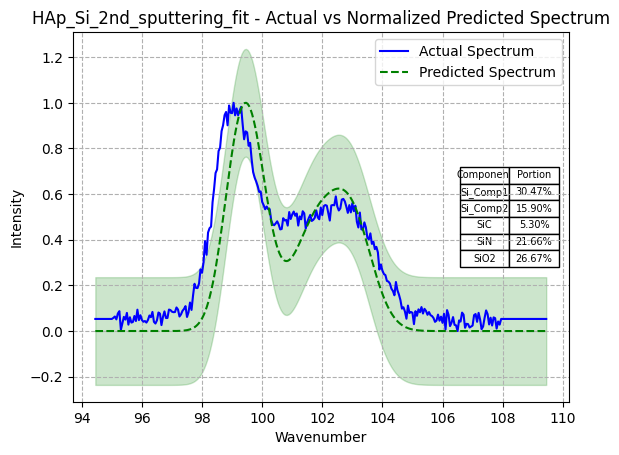

In [42]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
import os

np.random.seed(56)
random.seed(56)
tf.random.set_seed(56)
# Load the saved model
model = load_model('CNN_Model_Component_Binding_Energies_v3.h5')

# Function to generate multiple spectra as a sum of Gaussians
def generate_multiple_spectra(amplitudes, centers, fwhms):
    x_range = np.arange(94.45, 109.45, 0.05)
    peaks = []
    for i in range(len(centers)):
        fwhm = fwhms[i]
        if i == 1:  # For Si_Comp2
            peak = amplitudes[0] * np.exp(-(x_range - centers[i])**2 / (2 * (fwhm / (2 * np.sqrt(2 * np.log(2))))**2))  # Gaussian peak with FWHM, multiplied by 0.5 for intensity ratio
        else:
            peak = amplitudes[i] * np.exp(-(x_range - centers[i])**2 / (2 * (fwhm / (2 * np.sqrt(2 * np.log(2))))**2))  # Gaussian peak with FWHM
        peaks.append(peak)
    return np.sum(peaks, axis=0)

# Define components with binding energies and FWHMs
# Adjusted specific frequencies with conditional random value additions
freq_Si_Comp1 = 99.0 + np.random.uniform(-0.1, 0.1)
freq_Si_Comp2 = freq_Si_Comp1 + 0.6

components = {
    freq_Si_Comp1: ('Si_Comp1', 1.20),
    freq_Si_Comp2: ('Si_Comp2', 1.20),  # Set FWHM of Si_Comp2 same as Si_Comp1
    100.4 + np.random.uniform(-0.5, 0.5): ('SiC', 1.65),
    101.6 + np.random.uniform(-0.3, 0.3): ('SiN', 1.65),
    103.1 + np.random.uniform(-0.3, 0.3): ('SiO2', 1.65)
}

# Convert component frequencies to float
centers = list(components.keys())

# Load new data from CSV
file_path = 'ExperimentalData/HAp_Si_2nd_sputtering_fit.csv'
data = pd.read_csv(file_path, names=["Wavenumber", "Intensity"])
file_name = os.path.splitext(os.path.basename(file_path))[0]  # Extracts the file name without extension

# Define spectrum range
spectrum_min, spectrum_max = 94.45, 109.45

data['Wavenumber'] = pd.to_numeric(data['Wavenumber'], errors='coerce')
data['Intensity'] = pd.to_numeric(data['Intensity'], errors='coerce')

# Filter data within the specified wavenumber range
filtered_data = data[(data['Wavenumber'] >= spectrum_min) & (data['Wavenumber'] <= spectrum_max)].copy()
filtered_data = filtered_data.dropna(subset=['Intensity'])

# Preprocess the filtered data
min_value = np.min(filtered_data['Intensity'])
max_value = np.max(filtered_data['Intensity'])
spectraData_normalized = (filtered_data['Intensity'] - min_value) / (max_value - min_value)
filtered_data['Intensity'] = spectraData_normalized

# Prepare data for interpolation
x = filtered_data['Wavenumber']
y = filtered_data['Intensity']
x_normalized = (x - spectrum_min) / (spectrum_max - spectrum_min)

# Define the number of specific frequencies
num_specific_frequencies = 4

# Interpolate intensity values
f = interp1d(x_normalized, y, kind='linear', fill_value="extrapolate")
start = 94.45
end = 109.45
step = 0.05
num_points = int((end - start) / step)
new_x = np.linspace(0, 1, num_points)

interpolated_intensity = f(new_x)
interpolated_intensity = interpolated_intensity.reshape(1, -1, 1)  # Reshape for prediction

# Predict amplitudes
predicted_amplitudes = model.predict(interpolated_intensity)
predicted_amplitudes_flat = predicted_amplitudes.flatten()

# Calculate the spectrum of predicted amplitudes
predicted_spectrum = generate_multiple_spectra(predicted_amplitudes_flat, centers, [comp[1] for comp in components.values()])

# Normalize the predicted spectrum
predicted_spectrum_normalized = (predicted_spectrum - np.min(predicted_spectrum)) / (np.max(predicted_spectrum) - np.min(predicted_spectrum))

# Calculate the total intensity of the predicted spectrum after normalization
total_intensity_normalized = np.sum(predicted_spectrum_normalized)

# Plot both the actual and normalized predicted spectra
plt.plot(filtered_data['Wavenumber'], filtered_data['Intensity'], label='Actual Spectrum', color='blue', linestyle='-')

plt.plot(new_x * (spectrum_max - spectrum_min) + spectrum_min, predicted_spectrum_normalized, label='Predicted Spectrum', color='green', linestyle='--')

# Calculate the standard deviation of the predicted spectrum
std_predicted_spectrum = np.std(predicted_spectrum)

# Fill between predicted spectrum +/- 1 standard deviation
plt.fill_between(new_x * (spectrum_max - spectrum_min) + spectrum_min, predicted_spectrum_normalized - std_predicted_spectrum, predicted_spectrum_normalized + std_predicted_spectrum, color='green', alpha=0.2)

# Add a table with labels for the portions of each component based on predicted amplitudes
total_intensity = np.sum(predicted_amplitudes_flat)
table_data = [['Component', 'Portion']]
for component_freq, (component_name, _) in components.items():
    component_amplitude = predicted_amplitudes_flat[centers.index(component_freq)]
    portion = component_amplitude / total_intensity
    table_data.append([component_name, f'{portion * 100:.2f}%'])

# Create a table with custom font properties
table = plt.table(cellText=table_data, loc='center right', colWidths=[0.1, 0.1], cellLoc='center', colLabels=None)
table.auto_set_font_size(False)
table.set_fontsize(7)

# Add file name to the plot title
plt.title(f'{file_name} - Actual vs Normalized Predicted Spectrum')

plt.xlabel('Wavenumber')
plt.ylabel('Intensity')
plt.legend()
# plt.gca().invert_xaxis()
plt.grid(True, which="both", ls="--")
plt.show()
